In [1]:
# !pip install catboost

In [2]:
from catboost import CatBoostClassifier, Pool, MetricVisualizer, cv

import pandas as pd
import numpy as np

# Read data

In [3]:
USE_FULL = True

filename = 'data/training_set_VU_DM.csv'

if USE_FULL:
    df = pd.read_csv(filename)
else:
    import random
    p = 0.1
    df = pd.read_csv(filename,
                     header=0,
                     skiprows=lambda i: i > 0 and random.random() > p)

df['date_time'] = pd.to_datetime(df['date_time'])
df.shape

(4958347, 54)

# Simple preproc + split

In [4]:
CAT_FEATURES = ['site_id',
            'visitor_location_country_id',
            'prop_country_id',
            'prop_id',
            'srch_destination_id']

bool_cols = ['prop_brand_bool',
             'promotion_flag',
             'srch_saturday_night_bool',
             'random_bool']

group_col = 'srch_id'


def get_target(row):
    """
    0=not clicked at all, 1=clicked but not booked, 5=booked
    """
    if row.booking_bool>0:
        return 5
    if row.click_bool>0 :
        return 1
    return 0

clf_target = 'target'
df[clf_target] = df.apply(get_target, axis=1)

In [5]:
from utils import train_test_group_split

df.sort_values([group_col, 'date_time'], inplace=True)
# .drop(['position', 'click_bool', 'gross_bookings_usd', 'booking_bool'], axis=1)
X = df
y = df[clf_target]
groups = X[group_col]


X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_group_split(X, y, groups,
                                                                                     group_array=groups,
                                                                                     train_size=0.9)

X_train, X_val, y_train, y_val, groups_train, groups_val = train_test_group_split(X_train, y_train,
                                                                                  groups_train,
                                                                                  group_array=groups_train,
                                                                                  train_size=0.9)

# from sklearn.model_selection import GroupShuffleSplit  # ignores time
# gss = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
# >>> gss.get_n_splits()
# 2
# >>> for train_idx, test_idx in gss.split(X, y, groups):
# ...     print("TRAIN:", train_idx, "TEST:", test_idx)

In [6]:
X_train.shape, X_val.shape, X_test.shape

((4016231, 55), (446260, 55), (495856, 55))

In [7]:
set(X_train[group_col]).intersection(set(X_test[group_col]))

set()

In [8]:
drop_cols = ['position', 'click_bool',
             'gross_bookings_usd', 'booking_bool', clf_target]

train_pool = Pool(data=X_train.drop(drop_cols, axis=1),
                  label=y_train,
                  group_id=groups_train,
                  cat_features=CAT_FEATURES,
                  )

val_pool = Pool(data=X_val.drop(drop_cols, axis=1),
                label=y_val,
                group_id=groups_val,
                cat_features=CAT_FEATURES,
                )

test_pool = Pool(
    data=X_test.drop(drop_cols, axis=1),
    label=y_test,
    group_id=groups_test,
    cat_features=CAT_FEATURES,
)

# Fit final model

In [9]:
params = {
    "iterations": 100,
    #           'loss_function': 'NDCG:top=5',
    'loss_function': 'MultiClass',
    'custom_metric': ['AUC'],
    "verbose": False,
    'early_stopping_rounds': 10,
    #     'logging_level': 'Silent',
    'task_type': "CPU",
#     'auto_class_weights': 'Balanced',
    "use_best_model": True
}

In [10]:
CAT_FEATURES

['site_id',
 'visitor_location_country_id',
 'prop_country_id',
 'prop_id',
 'srch_destination_id']

In [11]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Eval on test

In [12]:
test_preds = np.float32(np.squeeze(model.predict(test_pool)))
test_preds[test_preds == 0.] = 0.01  # to make them orderable
test_pred_probs = model.predict_proba(test_pool)

In [13]:
X_train[clf_target].value_counts(normalize=True)

0    0.955286
5    0.027861
1    0.016853
Name: target, dtype: float64

In [14]:
pd.Series(np.squeeze(test_preds)).value_counts(normalize=True)

0.01    0.99972
5.00    0.00027
1.00    0.00001
dtype: float64

In [15]:
test_preds_weighted = np.max(test_pred_probs, axis=1) * np.squeeze(test_preds)

In [16]:
model.classes_

array([0, 1, 5])

In [17]:
test_preds = model.predict_proba(test_pool)[:,1]

test_results_df = pd.DataFrame({group_col: groups_test,
                        'prop_id': X_test['prop_id'],
                        clf_target+'_pred': test_preds,
                        clf_target+'_gt': y_test,
                         })
test_results_df.sort_values(by=[group_col, clf_target+'_pred'],
                            ascending=[True, False], inplace=True)

test_results_df.head()

,srch_id,prop_id,target_pred,target_gt
4462495,299424,19005,0.010525,0
4462515,299424,109781,0.010401,0
4462494,299424,18873,0.008357,0
4462506,299424,59976,0.008135,5
4462508,299424,67489,0.007943,0


In [18]:
from metrics import ndcg

print('NDCG which is used for competition evaluation')
test_results_df.groupby('srch_id')[clf_target+'_gt'].apply(ndcg, at=5).mean()

NDCG which is used for competition evaluation


0.3548803135505235

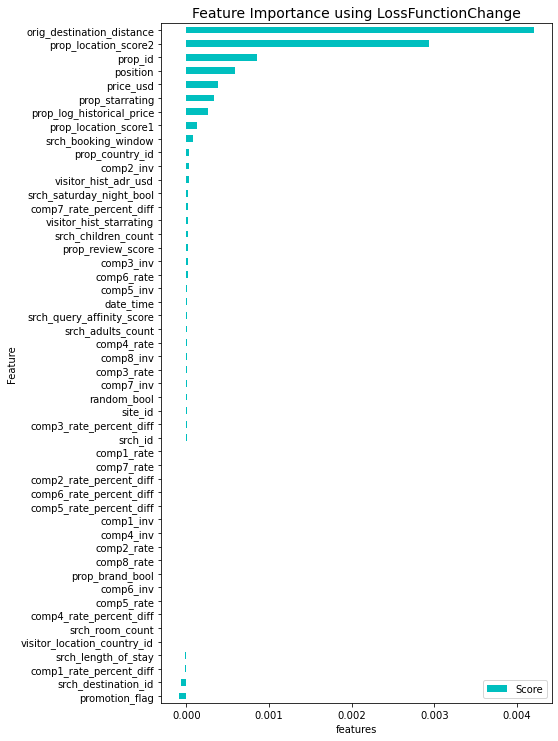

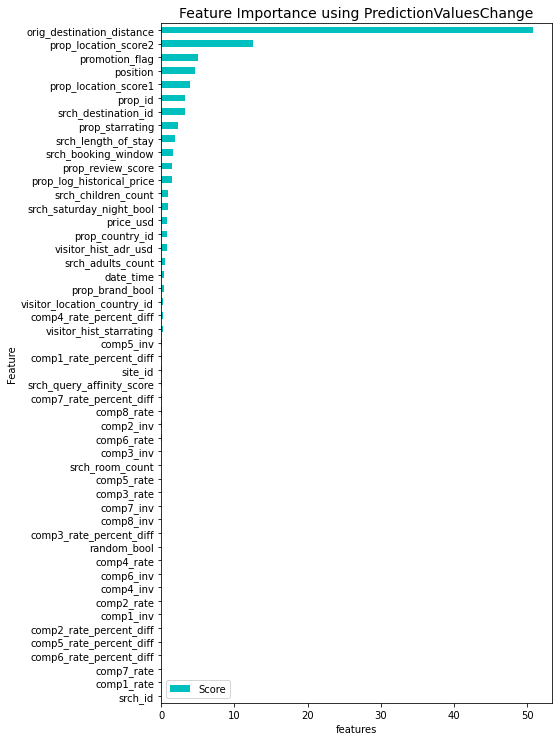

In [22]:
import matplotlib.pyplot as plt

for method in ['LossFunctionChange', 'PredictionValuesChange']:
    fi = model.get_feature_importance(test_pool, type=method)
    feature_score_raw = pd.DataFrame(list(zip(X_test.columns, fi)),
                                     columns=['Feature', 'Score'])

    feature_score = feature_score_raw.sort_values(
        by='Score', ascending=False)

    plt.rcParams["figure.figsize"] = (7, len(feature_score) / 4)
    ax = feature_score.plot('Feature', 'Score', kind='barh', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize=14)
    ax.set_xlabel("features")
    ax.invert_yaxis()
    plt.show()

# Make preds

In [19]:
# # subm_df = pd.read_csv('data/test_set_VU_DM.csv')
# subm_df['date_time'] = pd.to_datetime(subm_df['date_time'])

# subm_pool = Pool(
#     data=subm_df,
#     group_id=subm_df[group_col],
#     cat_features=CAT_FEATURES,
# )

In [20]:
# pred = model.predict(subm_pool)

# output_df = pd.DataFrame({group_col: subm_df[group_col],
#                         'prop_id': subm_df['prop_id'],
#                         clf_target: pred,
# #                         'gt': y_test
#                          })

# output_df.sort_values([group_col, 'position'], inplace=True)
# output_df[[group_col, 'prop_id']].to_csv('sumbission.csv', index=False)
# output_df.head(10)

In [21]:
# pd.read_csv('sumbission.csv', nrows=10)